<a href="https://colab.research.google.com/github/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/blob/main/MV_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Objective: Predict Monthly Crude Palm Oil Price Using Convolutional Neural Network (CNN)

In [1]:
!pip install scikeras
!pip install bayesian-optimization
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 7.6 MB/s 
     |████████████████████████████████| 1.6 MB 15.8 MB/s 


###Load Libraries

In [73]:
from numpy.random import seed
seed(1)
import tensorflow as tf
tf.random.set_seed(1)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (10, 5)
plt.style.use('fivethirtyeight')
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import tensorflow as tf
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer, mean_squared_error
from keras.layers import Dense, Dropout
from sklearn.metrics import explained_variance_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import KFold, cross_val_score
from scikeras.wrappers import KerasRegressor
from tensorflow import keras
from kerastuner.tuners import RandomSearch
from kerastuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization
from time import time

import matplotlib.dates as mdates
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler

###Define Functions to Facilitate Metrics Evaluation

In [3]:
#To compute Mean Directional Accuracy
def mda(actual: np.ndarray, predicted: np.ndarray):
    """ Mean Directional Accuracy """
    return np.mean((np.sign(actual[1:] - actual[:-1]) == np.sign(predicted[1:] - predicted[:-1])).astype(int))

#Calculate the Mean Absolute Percentage Error
#def MAPE(y_true, y_pred): 
    #mape = np.mean(np.abs((np.array(y_true) - np.array(y_pred)) / np.array(y_true))) * 100
    #return mape

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

#Calculate the Root Mean Squared Error:
def RMSE(y_true, y_pred): 
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return rmse

###Load the Cleaned Data from Github

In [4]:
from pandas import read_csv
path = 'https://raw.githubusercontent.com/mofuoku417/Machine-Learning-Techniques-for-Multivariate-Time-Series-Forecasting-of-Crude-Palm-Oil-Prices/main/Cleaned_data/df_final.csv'
df = read_csv(path)
df.head()

,date,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,srad,q_mm,humidity
0,2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0,28.67,207.70504,117.7,79.261905
1,2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0,24.49,228.94287,4.5,82.193548
2,2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0,22.06,238.41747,25.1,74.839286
3,2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0,21.64,218.47599,53.6,77.935484
4,2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0,22.30,226.15010,166.0,80.450000


In [5]:
df.index = pd.to_datetime(df['date'], format='%Y.%m.%d')
del df['date']

In [6]:
df.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,srad,q_mm,humidity
date,,,,,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0,28.67,207.70504,117.7,79.261905
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0,24.49,228.94287,4.5,82.193548
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0,22.06,238.41747,25.1,74.839286
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0,21.64,218.47599,53.6,77.935484
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0,22.30,226.15010,166.0,80.450000


<Figure size 1800x720 with 0 Axes>

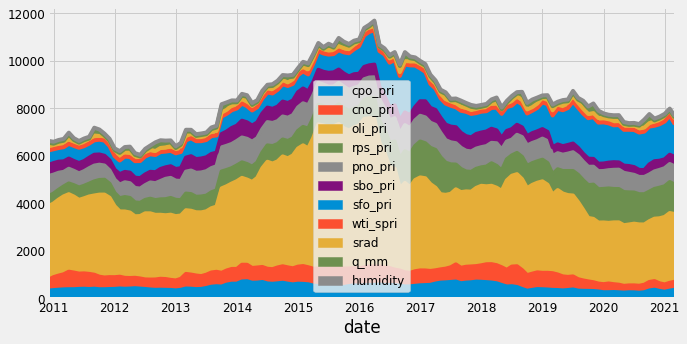

In [7]:
# Plot an area chart
plt.figure(figsize=(25,10))
ax = df.plot.area(fontsize=12);

# Additional customizations
ax.set_xlabel('date');
ax.legend(fontsize=12);

##**Convolutional Neural Network Forecasting Technique (CNN)**

###**Split Data into Train Test Segments**

In [8]:
train_size = int(len(df) * 0.8)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print('Train size:',len(train))
print('Test size:', len(test))

Train size: 99
Test size: 25


In [9]:
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(len(train), len(test))

99 25


In [10]:
print(train.shape)
train.head()

(99, 11)


,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,srad,q_mm,humidity
date,,,,,,,,,,,
2010-12-01,323,455,3102.61,423.45,844.0,468.0,578.0,28.67,207.70504,117.7,79.261905
2011-01-01,345,546,3100.45,415.85,799.0,485.0,557.0,24.49,228.94287,4.5,82.193548
2011-02-01,362,595,3199.41,410.77,718.0,466.0,552.0,22.06,238.41747,25.1,74.839286
2011-03-01,376,636,3281.67,414.82,614.0,442.0,574.0,21.64,218.47599,53.6,77.935484
2011-04-01,383,738,3261.65,451.04,619.0,429.0,595.0,22.30,226.15010,166.0,80.450000


###Rescaling Training Data

In [11]:
f_transformer = MinMaxScaler()
feature_columns = ['cno_pri', 'oli_pri', 'rps_pri', 'pno_pri', 'sbo_pri', 'sfo_pri',
                   'wti_spri', 'srad', 'q_mm', 'humidity']
f_transformer = f_transformer.fit(train[feature_columns].to_numpy())
train.loc[:, feature_columns] = f_transformer.transform(train[feature_columns].to_numpy())
train.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,srad,q_mm,humidity
date,,,,,,,,,,,
2010-12-01,323,0.112288,0.140918,0.010736,0.528090,0.253193,0.023302,0.109026,0.617026,0.366984,0.843364
2011-01-01,345,0.305085,0.140327,0.004301,0.443820,0.306536,0.009321,0.044200,0.815738,0.007619,0.983088
2011-02-01,362,0.408898,0.167408,0.000000,0.292135,0.246917,0.005992,0.006514,0.904388,0.073016,0.632580
2011-03-01,376,0.495763,0.189919,0.003429,0.097378,0.171609,0.020639,0.000000,0.717805,0.163492,0.780147
2011-04-01,383,0.711864,0.184440,0.034095,0.106742,0.130817,0.034621,0.010236,0.789608,0.520317,0.899990


In [12]:
cpo_pri_transformer = MinMaxScaler()
cpo_pri_transformer = cpo_pri_transformer.fit(train[['cpo_pri']])
train['cpo_pri'] = cpo_pri_transformer.transform(train[['cpo_pri']])
train['cpo_pri'].head()

date
2010-12-01    0.0100
2011-01-01    0.0650
2011-02-01    0.1075
2011-03-01    0.1425
2011-04-01    0.1600
Name: cpo_pri, dtype: float64

In [13]:
test.loc[:, feature_columns] = f_transformer.transform(test[feature_columns].to_numpy())
test.head()

,cpo_pri,cno_pri,oli_pri,rps_pri,pno_pri,sbo_pri,sfo_pri,wti_spri,srad,q_mm,humidity
date,,,,,,,,,,,
2019-03-01,354,0.637712,0.194855,0.382454,0.381292,-0.039662,0.493342,0.455180,0.707023,0.548889,0.265874
2019-04-01,348,0.533898,0.264388,0.393951,0.213633,-0.054975,0.597870,0.515974,0.732180,0.017143,0.437683
2019-05-01,332,0.400424,0.246417,0.453802,0.235262,-0.092159,0.606525,0.530397,0.708895,0.444127,0.349664
2019-06-01,349,0.317797,0.234308,0.509834,0.320749,-0.074743,0.631824,0.593207,0.808476,0.181905,0.645800
2019-07-01,372,0.313559,0.223422,0.526454,0.426610,-0.066114,0.773462,0.641749,0.866202,0.436825,0.577974


In [14]:
test['cpo_pri'] = cpo_pri_transformer.transform(test[['cpo_pri']])
test['cpo_pri'].head()

date
2019-03-01    0.0875
2019-04-01    0.0725
2019-05-01    0.0325
2019-06-01    0.0750
2019-07-01    0.1325
Name: cpo_pri, dtype: float64

###Create X_train, y_train, X_test and y_test

In [15]:
def createDataset(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        data = X.iloc[i:(i + time_steps)].values
        Xs.append(data)        
        ys.append(y.iloc[i + time_steps])
        
    return np.array(Xs), np.array(ys)

time_steps = 3
X_train, y_train = createDataset(train, train.cpo_pri, time_steps)
X_test, y_test = createDataset(test, test.cpo_pri, time_steps)
print(X_train.shape, y_train.shape)

(96, 3, 11) (96,)


In [ ]:
#test_lag = test[1:23]
#len(test) - 1

In [ ]:
#decrement naturally.
#shifted = test.set_index(["date"]).unstack().shift(3).stack()

In [22]:
cnn_model = tf.keras.Sequential()
cnn_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, activation='tanh', input_shape=(X_test.shape[1], X_test.shape[2])))
cnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_model.add(tf.keras.layers.Flatten())
cnn_model.add(tf.keras.layers.Dense(50, activation='tanh'))
cnn_model.add(tf.keras.layers.Dense(1, 'tanh'))

# compile model using adam
cnn_model.compile(optimizer='adam',loss='mse',metrics=['mse'])
# model training
history = cnn_model.fit(X_train, y_train, validation_split=0.2, epochs=40)

# model evaluation
cnn_model.evaluate(X_test, y_test)


#cnn_model.compile(loss='mse', optimizer='adam')
#cnn_model.summary()

Epoch 1/40
3/3 [==============================] - 1s 101ms/step - loss: 0.6442 - mse: 0.6442 - val_loss: 0.1612 - val_mse: 0.1612
Epoch 2/40
3/3 [==============================] - 0s 15ms/step - loss: 0.0995 - mse: 0.0995 - val_loss: 0.0768 - val_mse: 0.0768
Epoch 3/40
3/3 [==============================] - 0s 15ms/step - loss: 0.0566 - mse: 0.0566 - val_loss: 0.1317 - val_mse: 0.1317
Epoch 4/40
3/3 [==============================] - 0s 15ms/step - loss: 0.1027 - mse: 0.1027 - val_loss: 0.1572 - val_mse: 0.1572
Epoch 5/40
3/3 [==============================] - 0s 25ms/step - loss: 0.1203 - mse: 0.1203 - val_loss: 0.1589 - val_mse: 0.1589
Epoch 6/40
3/3 [==============================] - 0s 26ms/step - loss: 0.1151 - mse: 0.1151 - val_loss: 0.1448 - val_mse: 0.1448
Epoch 7/40
3/3 [==============================] - 0s 28ms/step - loss: 0.0934 - mse: 0.0934 - val_loss: 0.1199 - val_mse: 0.1199
Epoch 8/40
3/3 [==============================] - 0s 22ms/step - loss: 0.0648 - mse: 0.0648 - va

[0.023465590551495552, 0.023465590551495552]

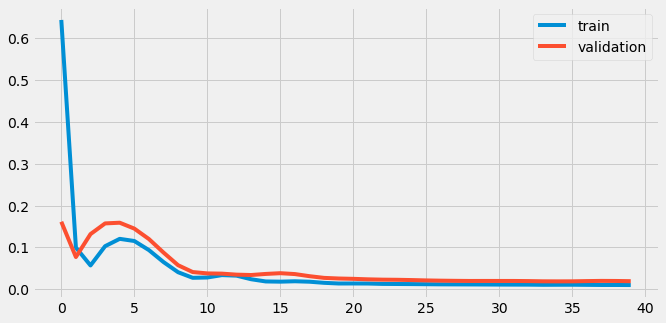

In [23]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [24]:
mse_cnn = cnn_model.evaluate(X_test, y_test)

1/1 [==============================] - 0s 22ms/step - loss: 0.0235 - mse: 0.0235


####Baseline MSE = 0.0235

In [25]:
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 2, 64)             1472      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 1, 64)            0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                3250      
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 4,773
Trainable params: 4,773
Non-trainable params: 0
____________________________________________________

###Predict the Test without Hyperparameter Tuning

In [26]:
y_pred = cnn_model.predict(X_test)
y_pred

1/1 [==============================] - 0s 65ms/step


array([[ 0.09558691],
       [ 0.09531268],
       [ 0.11831614],
       [ 0.13203107],
       [ 0.0768607 ],
       [-0.08554846],
       [-0.08990945],
       [-0.11283954],
       [-0.05122636],
       [-0.08084571],
       [ 0.00967751],
       [-0.01869365],
       [-0.02666637],
       [ 0.03150993],
       [ 0.06836009],
       [ 0.07900868],
       [-0.04922423],
       [-0.11377449],
       [ 0.07693285],
       [ 0.22461388],
       [ 0.16006175],
       [ 0.15434012]], dtype=float32)

In [27]:
y_pred.reshape(1,-1)

array([[ 0.09558691,  0.09531268,  0.11831614,  0.13203107,  0.0768607 ,
        -0.08554846, -0.08990945, -0.11283954, -0.05122636, -0.08084571,
         0.00967751, -0.01869365, -0.02666637,  0.03150993,  0.06836009,
         0.07900868, -0.04922423, -0.11377449,  0.07693285,  0.22461388,
         0.16006175,  0.15434012]], dtype=float32)

###Invert Transformed Data

In [28]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[357.23477 357.12506 366.32645 371.81244 349.74426 284.7806  283.03622
  273.86417 298.50946 286.6617  322.871   311.52252 308.33344 331.60397
  346.34406 350.6035  299.3103  273.4902  349.77313 408.84558 383.0247
  380.73605]]


###Plot History, Actual and Predicted Value

In [29]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [30]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [31]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([357.23477, 357.12506, 366.32645, 371.81244, 349.74426, 284.7806 ,
       283.03622, 273.86417, 298.50946, 286.6617 , 322.871  , 311.52252,
       308.33344, 331.60397, 346.34406, 350.6035 , 299.3103 , 273.4902 ,
       349.77313, 408.84558, 383.0247 , 380.73605], dtype=float32)

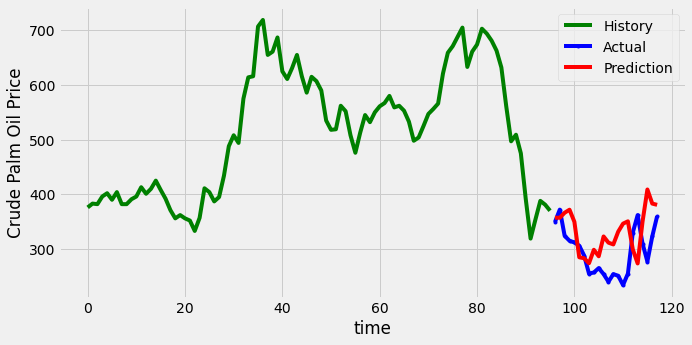

In [32]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('time')
plt.legend()
plt.show();

###Evaluate CNN Model Accuracy

In [34]:
MAE_cnn = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the CNN Model is:', MAE_cnn)

MDA_cnn = mda(y_test_inv, y_pred_inv)
print('MDA value of the CNN Model is:', MDA_cnn)

MAPE_cnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the CNN Model is:', MAPE_cnn)

RMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the CNN Model is:', RMSE_cnn)

MSE_cnn = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the CNN Model is:', MSE_cnn)

#EVS_cnn = explained_variance_score(y_test_inv, y_pred_inv)
#print('EVS score of the CNN Model is:', EVS_cnn)

MAE value of the CNN Model is: 51.04858121004972
MDA value of the CNN Model is: 0.3333333333333333
MAPE value of the CNN Model is: 18.38089285966654
RMSE value of the CNN Model is: 61.273930133329074
MSE value of the CNN Model is: 3754.4945139840925


####Actual VS Predicted CNN Model

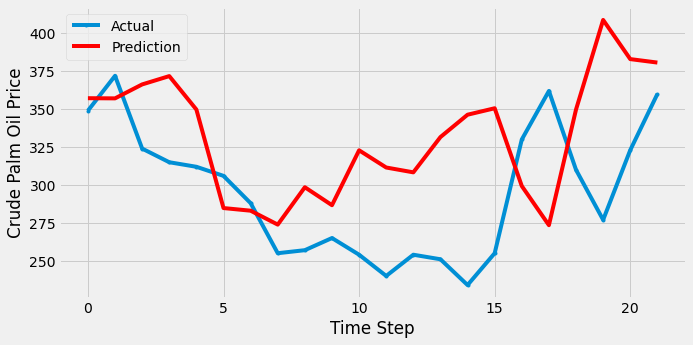

In [35]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

###Tuning CNN with Keras Tuner

In [68]:
class ANNhypermodel(HyperModel):
#class CNNHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape= input_shape
        
    def build(self, hp):
        model= keras.Sequential()
        
        # Tune the number of units in the first Dense layer
        # Defining dense units as a close approx to the original neural network to perform a fair comparision!
        
        
        hp_units_1= hp.Int('units_1', min_value=128, max_value= 160, step=32)
        hp_units_2= hp.Int('units_2', min_value=64, max_value= 128, step=32)
        hp_units_3= hp.Int('units_3', min_value=32, max_value= 64, step=16)

        model.add(keras.layers.Dense(units=hp_units_1, activation='relu', input_shape= self.input_shape))
        model.add(keras.layers.Dense(units=hp_units_2, activation='relu'))
        model.add(keras.layers.Dense(units=hp_units_3, activation='relu'))
        model.add(keras.layers.Dense(1))

        #Tune the dropout
        model.add(
            Dropout(
                rate=hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.25,
                    step=0.05
                )
            )
        )

        # Tune the learning rate for the optimizer 
        hp_learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG', default= 0.0005)

        model.compile(loss='mse',
                    optimizer= keras.optimizers.Adam(learning_rate=hp_learning_rate),
                    metrics= ['mae','mse']
                     )

        return model

hypermodel= ANNhypermodel(input_shape = (X_test.shape[1], X_test.shape[2]))
#hypermodel = CNNHyperModel(input_shape = (X_test.shape[1], X_test.shape[2]))

###Build Random Search Tuner

In [60]:
tuner_rs = RandomSearch(
            hypermodel,
            objective='mse',
            seed=42,
            max_trials=10,
            executions_per_trial=2, overwrite=True
        )

###Run Random Search

In [61]:
tuner_rs.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

###Evaluate Random Search

In [50]:
best_model = tuner_rs.get_best_models(num_models=1)[0]
mse_rs = best_model.evaluate(X_test, y_test)[1]

1/1 [==============================] - 0s 437ms/step - loss: 0.3334 - mse: 0.3334


####Random Search MSE = 0.3334

In [54]:
best_params = tuner_rs.get_best_hyperparameters()

best_params[0].values

{'units_1': 160,
 'units_2': 96,
 'units_3': 64,
 'dropout': 0.05,
 'learning_rate': 0.008547485565344062}

###Build Bayesian Optimization

In [57]:
tuner_bo = BayesianOptimization(
            hypermodel,
            objective='val_mse',
            max_trials=10,
            seed=42,
            executions_per_trial=2,
            directory='bo'
        )

###Run Bayesian Optimization

In [ ]:
tuner_bo.search(X_train, y_train, epochs=10, validation_split=0.2, verbose=0)

best_model = tuner_bo.get_best_models(num_models=1)[0]
mse_bo = best_model.evaluate(X_test, y_test)[1]

###Evaluate Bayesian Optimization

In [70]:
best_params = tuner_bo.get_best_hyperparameters()

best_params[0].values

{'units': 64,
 'dense_activation': 'relu',
 'dropout': 0.0,
 'num_hidden_layers': 10.0,
 'neurons_per_layer': 97.0,
 'batch_size': 30.0,
 'learning_rate': 0.01,
 'units_1': 128,
 'units_2': 64,
 'units_3': 32}

###Build HYPERBAND optimization

In [ ]:
MAX_TRIALS = 20
tuner= RandomSearch(hypermodel,
               objective= 'val_mse',
               max_trials= MAX_TRIALS,
               executions_per_trial= 2,
               directory= 'random_search',
               project_name='randomsearch',
               overwrite=True)

In [71]:
HYPERBAND_MAX_EPOCHS = 150
EXECUTION_PER_TRIAL = 2

tuner= Hyperband(hypermodel,
                   objective= 'val_mse',
                   max_epochs=HYPERBAND_MAX_EPOCHS, #Set 100+ for good results
                   executions_per_trial=EXECUTION_PER_TRIAL,
                   directory= 'hyperband',
                   project_name='hyper',
                   overwrite=True)

# tuner.search_space_summary()

In [74]:
print('searching for the best params!')

t0 = time()
tuner.search(x= X_train,
             y= y_train,
             epochs=100,
             batch_size= 64,
             validation_data= (X_test, y_test),
             verbose=0,
             callbacks= []
            )
print(time()- t0," secs")

# Retreive the optimal hyperparameters
best_hps= tuner.get_best_hyperparameters(num_trials=1)[0]

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

searching for the best params!


990.2068428993225  secs


In [75]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is {best_hps.get('units_1')},
second layer is {best_hps.get('units_2')} 
third layer is {best_hps.get('units_3')} 
drop out is {best_hps.get('dropout')}
#learning rate is {best_hps.get('learning_rate')}                                        

and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Evaluate the best model.
print(best_model.metrics_names)
loss, mae, mse = best_model.evaluate(X_test, y_test)
print(f'loss:{loss} mae: {mae} mse: {mse}')


The hyperparameter search is complete. The optimal number of units in the 
first densely-connected layer is 128,
second layer is 96 
third layer is 64 
drop out is 0.25
#learning rate is 0.00011176675024605938                                        

and the optimal learning rate for the optimizer
is 0.00011176675024605938.

[]
1/1 [==============================] - 0s 385ms/step - loss: 0.0117 - mae: 0.0953 - mse: 0.0117
loss:0.011714454740285873 mae: 0.0953293964266777 mse: 0.011714453808963299


####Hyperband MSE = 0.0117

###Apply tuned parameter

In [82]:
TUcnn_model = tf.keras.Sequential()
TUcnn_model.add(tf.keras.layers.Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_test.shape[1], X_test.shape[2])))
TUcnn_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
TUcnn_model.add(tf.keras.layers.Flatten())
TUcnn_model.add(tf.keras.layers.Dense(96, activation='tanh'))
TUcnn_model.add(tf.keras.layers.Dense(64, activation='tanh'))
TUcnn_model.add(layers.Dropout(0.25))

TUcnn_model.add(tf.keras.layers.Dense(1, 'tanh'))
# compile model using adam
#opt = tf.keras.optimizers.Adam(learning_rate=0.01)
TUcnn_model.compile(loss = 'mse', optimizer= tf.keras.optimizers.Adam(learning_rate=0.00011176675024605938 ), metrics= ['mae', 'mse'])
TUcnn_model.compile(optimizer='adam',loss='mse',metrics=['mse']),

history = TUcnn_model.fit(X_train, y_train, validation_split=0.2, epochs=100)

# model evaluation
TUcnn_model.evaluate(X_test, y_test)

Epoch 1/100
3/3 [==============================] - 1s 94ms/step - loss: 0.0872 - mse: 0.0872 - val_loss: 0.1090 - val_mse: 0.1090
Epoch 2/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0802 - mse: 0.0802 - val_loss: 0.1024 - val_mse: 0.1024
Epoch 3/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0495 - mse: 0.0495 - val_loss: 0.0680 - val_mse: 0.0680
Epoch 4/100
3/3 [==============================] - 0s 24ms/step - loss: 0.0299 - mse: 0.0299 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 5/100
3/3 [==============================] - 0s 13ms/step - loss: 0.0288 - mse: 0.0288 - val_loss: 0.0636 - val_mse: 0.0636
Epoch 6/100
3/3 [==============================] - 0s 14ms/step - loss: 0.0224 - mse: 0.0224 - val_loss: 0.0541 - val_mse: 0.0541
Epoch 7/100
3/3 [==============================] - 0s 16ms/step - loss: 0.0204 - mse: 0.0204 - val_loss: 0.0565 - val_mse: 0.0565
Epoch 8/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0264 - mse: 0.02

[0.01943974569439888, 0.01943974569439888]

In [84]:
y_pred2 = TUcnn_model.predict(X_test)
y_pred2

1/1 [==============================] - 0s 418ms/step


array([[ 0.03057668],
       [ 0.08018076],
       [ 0.10177404],
       [ 0.11643022],
       [ 0.00502573],
       [-0.08090357],
       [-0.10589901],
       [-0.12252001],
       [-0.17367375],
       [-0.11503052],
       [-0.00408253],
       [ 0.00439653],
       [-0.00411904],
       [ 0.0247994 ],
       [ 0.08486219],
       [ 0.0713888 ],
       [-0.02182286],
       [ 0.07420312],
       [ 0.12426668],
       [ 0.1715016 ],
       [ 0.07232006],
       [ 0.23260255]], dtype=float32)

In [85]:
y_pred2.reshape(1,-1)

array([[ 0.03057668,  0.08018076,  0.10177404,  0.11643022,  0.00502573,
        -0.08090357, -0.10589901, -0.12252001, -0.17367375, -0.11503052,
        -0.00408253,  0.00439653, -0.00411904,  0.0247994 ,  0.08486219,
         0.0713888 , -0.02182286,  0.07420312,  0.12426668,  0.1715016 ,
         0.07232006,  0.23260255]], dtype=float32)

In [86]:
y_train_inv = cpo_pri_transformer.inverse_transform(y_train.reshape(1, -1))
y_test_inv = cpo_pri_transformer.inverse_transform(y_test.reshape(1, -1))
y_pred_inv = cpo_pri_transformer.inverse_transform(y_pred2.reshape(1,-1))
print(y_train_inv)
print(y_test_inv)
print(y_pred_inv)

[[376. 383. 382. 396. 402. 390. 404. 382. 382. 391. 396. 413. 401. 410.
  425. 408. 392. 371. 356. 362. 356. 352. 333. 357. 411. 404. 387. 395.
  434. 488. 508. 494. 575. 614. 616. 707. 719. 655. 661. 687. 625. 611.
  631. 655. 616. 586. 615. 607. 590. 535. 518. 519. 562. 552. 508. 476.
  513. 545. 532. 550. 561. 567. 580. 559. 562. 553. 533. 498. 504. 525.
  547. 556. 566. 621. 659. 671. 688. 705. 633. 661. 674. 703. 694. 681.
  663. 632. 561. 497. 509. 475. 392. 319. 354. 388. 381. 370.]]
[[349. 372. 324. 315. 312. 306. 288. 255. 257. 265. 254. 240. 254. 251.
  234. 255. 330. 362. 310. 277. 323. 360.]]
[[331.23065 351.07233 359.70963 365.57208 321.01028 286.63858 276.64038
  269.992   249.5305  272.9878  317.36697 320.7586  317.3524  328.91977
  352.9449  347.5555  310.27084 348.68127 368.70667 387.60065 347.928
  412.04105]]


In [87]:
y_train_inv = y_train_inv.flatten()
y_train_inv

array([376., 383., 382., 396., 402., 390., 404., 382., 382., 391., 396.,
       413., 401., 410., 425., 408., 392., 371., 356., 362., 356., 352.,
       333., 357., 411., 404., 387., 395., 434., 488., 508., 494., 575.,
       614., 616., 707., 719., 655., 661., 687., 625., 611., 631., 655.,
       616., 586., 615., 607., 590., 535., 518., 519., 562., 552., 508.,
       476., 513., 545., 532., 550., 561., 567., 580., 559., 562., 553.,
       533., 498., 504., 525., 547., 556., 566., 621., 659., 671., 688.,
       705., 633., 661., 674., 703., 694., 681., 663., 632., 561., 497.,
       509., 475., 392., 319., 354., 388., 381., 370.])

In [88]:
y_test_inv = y_test_inv.flatten()
y_test_inv

array([349., 372., 324., 315., 312., 306., 288., 255., 257., 265., 254.,
       240., 254., 251., 234., 255., 330., 362., 310., 277., 323., 360.])

In [89]:
y_pred_inv = y_pred_inv.flatten()
y_pred_inv

array([331.23065, 351.07233, 359.70963, 365.57208, 321.01028, 286.63858,
       276.64038, 269.992  , 249.5305 , 272.9878 , 317.36697, 320.7586 ,
       317.3524 , 328.91977, 352.9449 , 347.5555 , 310.27084, 348.68127,
       368.70667, 387.60065, 347.928  , 412.04105], dtype=float32)

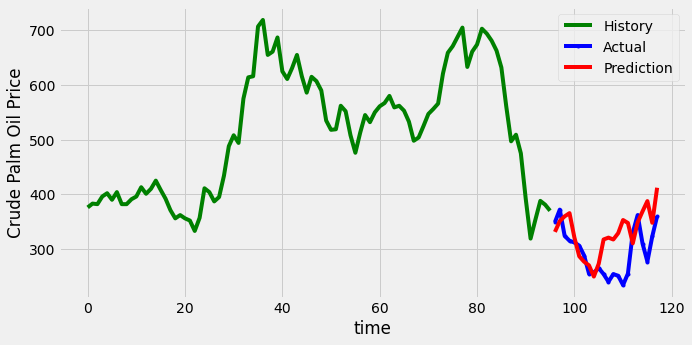

In [90]:
plt.plot(np.arange(0, len(y_train)), y_train_inv, color='green', label="History")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv, color='blue', marker='.', label="Actual")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('time')
plt.legend()
plt.show();

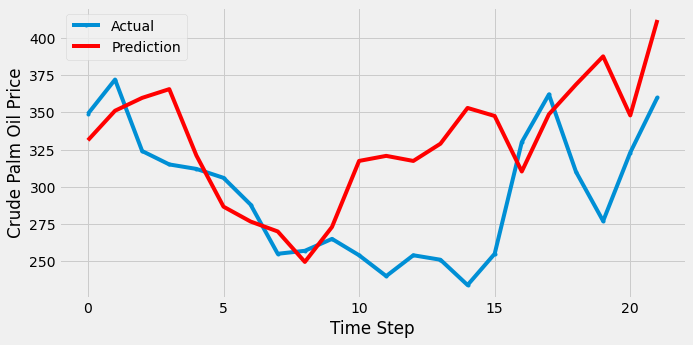

In [91]:
plt.plot(y_test_inv, marker='.', label="Actual")
plt.plot(y_pred_inv, color='red', label="Prediction")
plt.ylabel('Crude Palm Oil Price')
plt.xlabel('Time Step')
plt.legend()
plt.show();

In [93]:
MAE_cnn = mean_absolute_error(y_test_inv, y_pred_inv)
print('MAE value of the CNN Model is:', MAE_cnn)

MDA_cnn = mda(y_test_inv, y_pred_inv)
print('MDA value of the CNN Model is:', MDA_cnn)

MAPE_cnn = mean_absolute_percentage_error(y_test_inv, y_pred_inv)
print('MAPE value of the CNN Model is:', MAPE_cnn)

RMSE_cnn = mean_squared_error(y_test_inv,y_pred_inv, squared=False)
print('RMSE value of the CNN Model is:', RMSE_cnn)

MSE_cnn = mean_squared_error(y_test_inv,y_pred_inv)
print('MSE value of the CNN Model is:', MSE_cnn)

MAE value of the CNN Model is: 44.153714960271664
MDA value of the CNN Model is: 0.38095238095238093
MAPE value of the CNN Model is: 16.14362338430565
RMSE value of the CNN Model is: 55.77059695474604
MSE value of the CNN Model is: 3110.359484688728
